# Successive Elimination with minimum constraint

In [59]:
import numpy as np
from scipy.stats import bernoulli

#K groups,N arms/group, delta=confidence of success
# Bernoulli reward disrtibution
#reward distribution example 1:[[0.1,0.2,0.3,0.2],[0.6,0.6,0.6,0.6],[0.9,0.8,0.7,0.6]]
#reward distribution example 2:[[0.1,0.2,0.3,0.2],[0.1,0.1,0.1,0.1],[0.9,0.8,0.7,0.6]]--easier to distinguish
def successive_elimination_main_func():
    K=3;N=4;delta=1;min_threshold=0.15;
    reward_distribution=np.array([[0.1,0.2,0.3,0.2],[0.3,0.4,0.3,0.3],[0.9,0.8,0.7,0.6]]);
    pulls=np.ones((K,N));
    active_groups=np.ones(K);
    actual_reward_received=np.zeros((K,N));
    t=1;
    lcb_arms=np.zeros((K,N));ucb_arms=np.zeros((K,N));
    lcb_group=np.zeros(K);ucb_group=np.zeros(K);


    def eliminate_arms(active_groups,lcb_group,ucb_group):
        lcb_max=np.max(lcb_group);
        state_groups1=(ucb_group>=lcb_max);
        state_groups2=np.array(list(map(sum, (ucb_arms>=min_threshold))))>=1;
        active_groups*=state_groups1;
        return active_groups

    def calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms):
        lcb_arms=actual_reward_received/pulls-np.sqrt(np.log(4*t*t/delta)/(2*pulls));
        ucb_arms=actual_reward_received/pulls+np.sqrt(np.log(4*t*t/delta)/(2*pulls));
        lcb_group=lcb_arms.sum(axis=1);
        ucb_group=ucb_arms.sum(axis=1);
        return lcb_arms,ucb_arms,lcb_group,ucb_group;

    def eliminate_minviolating_arms(active_groups,lcb_arms,ucb_arms):
        for group in range(K):
            if active_groups[group]==1: 
                if np.prod(ucb_arms[group]>=min_threshold)==0 :
                    #print("ucb=",ucb_arms[group])
                    active_groups[group]=0;
                if np.prod(lcb_arms[group]>=min_threshold)==1:
                    active_groups[group]=2;  #2 =dormant group
        return active_groups      


    while np.bincount(np.int32(active_groups))[1]!=0 and t<=500000:
        for i in range(len(active_groups)):
            if active_groups[i]==1:

                for index in range(len(reward_distribution[i])):
                    pulls[i][index]+=1;
                    t=t+1;
                    actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);
        lcb_arms,ucb_arms,lcb_group,ucb_group=calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms);
        active_groups=eliminate_minviolating_arms(active_groups,lcb_arms,ucb_arms);
        #print(active_groups,"\n",lcb_arms,"\n",ucb_arms)

    #print(active_groups,"\n",lcb_arms,"\n",ucb_arms,"\n",t)

    while np.sum((active_groups>=1))>1 and t<=500000 :
        for i in range(len(active_groups)):
            if active_groups[i]>=1:

                for index in range(len(reward_distribution[i])):
                    pulls[i][index]+=1;
                    t=t+1;
                    actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);


        lcb_arms,ucb_arms,lcb_group,ucb_group=calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms);
        active_groups=eliminate_arms(active_groups,lcb_group,ucb_group);
        #print(lcb_group,ucb_group,"\n",pulls)

    #print("Stopping Time :",t)
    #print("Active arm :",active_groups)
    return t

In [61]:
successive_elimination_main_func()

18793

## Observations
####  1)if min_threshold==mean of one the arms then,it will take infinite time to discard that arm.
#### 2) we have to separate the process in two stages as,if the group confidence bounds separates first then the higher group might have a min_violating arm which is undesirable
####  3)Iterate until lcb of all arms goes above min_threshold(mark as dormant) or 
####   ucb of any arm goes below min_threshold(mark as inactive) 
####  4) Only dormant arms proceed to successive elimination stage.














# LUCB with minimum constraint
### Generally we try to separate the confidence intervals of the best and worst arm,similarly for minima I tried to separate group with max lcb less than the min_threshold(hoping that its lcb crosses the min_threshold and the entire group can become dormant(i.e group with no min_violating_arms))  and the group with least ucb greater than min_threshold

In [64]:
#LUCB

import numpy as np
from scipy.stats import bernoulli

#K groups,N arms/group, delta=confidence of success
# Bernoulli reward disrtibution
#reward distribution example 1:[[0.1,0.2,0.3,0.2],[0.6,0.6,0.6,0.6],[0.9,0.8,0.7,0.6]]
#reward distribution example 2:[[0.1,0.2,0.3,0.2],[0.1,0.1,0.1,0.1],[0.9,0.8,0.7,0.6]]--easier to distinguish

def LUCB_main_func():
    K=3;N=4;delta=1;min_threshold=0.15;
    reward_distribution=np.array([[0.1,0.2,0.3,0.2],[0.3,0.4,0.3,0.3],[0.9,0.8,0.7,0.6]]);
    pulls=np.ones((K,N));
    active_groups=np.ones(K);
    actual_reward_received=np.zeros((K,N));
    t=1;
    lcb_arms=np.zeros((K,N));ucb_arms=np.zeros((K,N));
    lcb_group=np.zeros(K);ucb_group=np.zeros(K);


    def eliminate_arms(active_groups,lcb_group,ucb_group):
        lcb_max=np.max(lcb_group);
        state_groups1=(ucb_group>=lcb_max);
        state_groups2=np.array(list(map(sum, (ucb_arms>=min_threshold))))>=1;
        active_groups*=state_groups1;
        return active_groups

    def calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms):
        lcb_arms=actual_reward_received/pulls-np.sqrt(np.log(4*t*t/delta)/(2*pulls));
        ucb_arms=actual_reward_received/pulls+np.sqrt(np.log(4*t*t/delta)/(2*pulls));
        lcb_group=lcb_arms.sum(axis=1);
        ucb_group=ucb_arms.sum(axis=1);
        return lcb_arms,ucb_arms,lcb_group,ucb_group;

    def eliminate_minviolating_arms(active_groups,lcb_arms,ucb_arms):
        for group in range(K):
            if active_groups[group]==1: 
                if np.prod(ucb_arms[group]>=min_threshold)==0 :
                    #print("ucb=",ucb_arms[group])
                    active_groups[group]=0;
                if np.prod(lcb_arms[group]>=min_threshold)==1:
                    active_groups[group]=2;  #2 =dormant group
        return active_groups  



    def minLCB_amongst_active_dormant_grps(active_groups,lcb_group):
        mn=1e6;arg_mn=0;
        for i in range(len(active_groups)):
            if active_groups[i]>=1:
                if(lcb_group[i]<=mn):
                    mn=lcb_group[i];
                    arg_mn=i;

        return arg_mn

    def maxUCB_amongst_active_dormant_grps(active_groups,ucb_group):
        mx=-1e6;arg_mx=0;
        for i in range(len(active_groups)):
            if active_groups[i]>=1:
                if(ucb_group[i]>=mx):
                    mx=lcb_group[i];
                    arg_mx=i;

        return arg_mx

    def closest_UCB_to_minthreshold_amongst_active_dormant_grps(active_groups,ucb_arms):
        mn=1e6;arg_mn_arm=0;arg_mn_grp=0;
        for i in range(len(active_groups)):
            if np.int(active_groups[i])==1:
                for j in range(len(ucb_arms[i])):
                    #print(mn,actual_reward_received[arg_mn_grp][arg_mn_arm]/pulls[arg_mn_grp][arg_mn_arm],arg_mn_arm,arg_mn_grp,"Hi")
                    if ucb_arms[i][j]>min_threshold and mn>ucb_arms[i][j]:
                        mn=ucb_arms[i][j]
                        arg_mn_grp=i;arg_mn_arm=j

        return arg_mn_grp,arg_mn_arm

    def closest_LCB_to_minthreshold_amongst_active_dormant_grps(active_groups,lcb_arms):
        mx=-1e6;arg_mx_arm=0;arg_mx_grp=0;
        for i in range(len(active_groups)):
            if active_groups[i]>=1:
                for j in range(len(lcb_arms[i])):
                    #print(mx,actual_reward_received[arg_mx_grp][arg_mx_arm]/pulls[arg_mx_grp][arg_mx_arm],arg_mx_arm,arg_mx_grp,"Hi_lcb")
                    #print(lcb_arms,"\n",actual_reward_received,"\n",np.sqrt(np.log(4*t*t/delta)/(2*pulls)),"\n",t,"\n")
                    if lcb_arms[i][j]<min_threshold and mx<lcb_arms[i][j]:
                        mx=lcb_arms[i][j]
                        arg_mx_grp=i;arg_mx_arm=j

        return arg_mx_grp,arg_mx_arm

    while np.bincount(np.int32(active_groups))[1]!=0 and t<=500000:
        """for i in range(len(active_groups)):
            if active_groups[i]==1:

                for index in range(len(reward_distribution[i])):
                    pulls[i][index]+=1;
                    t=t+1;
                    actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);"""

        lt,index_lt=closest_LCB_to_minthreshold_amongst_active_dormant_grps(active_groups,lcb_arms)
        ut,index_ut=closest_UCB_to_minthreshold_amongst_active_dormant_grps(active_groups,ucb_arms)

        pulls[lt][index_lt]+=1;
        t=t+1;
        actual_reward_received[lt][index_lt]+=bernoulli.rvs(p=reward_distribution[lt][index_lt]);

        pulls[ut][index_ut]+=1;
        t=t+1;
        actual_reward_received[ut][index_ut]+=bernoulli.rvs(p=reward_distribution[ut][index_ut]);

        lcb_arms,ucb_arms,lcb_group,ucb_group=calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms);
        active_groups=eliminate_minviolating_arms(active_groups,lcb_arms,ucb_arms);
        #print(active_groups,"\n",lcb_arms,"\n",ucb_arms)

    #print(active_groups,"\n",lcb_arms,"\n",ucb_arms,"\n",t)

    while np.sum((active_groups>=1))>1 and t<=500000 :
        #for i in range(len(active_groups)):
        lt=minLCB_amongst_active_dormant_grps(active_groups,lcb_group)
        ut=maxUCB_amongst_active_dormant_grps(active_groups,ucb_group)

        for index in range(len(reward_distribution[lt])):
            pulls[lt][index]+=1;
            t=t+1;
            actual_reward_received[lt][index]+=bernoulli.rvs(p=reward_distribution[lt][index]);

        for index in range(len(reward_distribution[ut])):
            pulls[ut][index]+=1;
            t=t+1;
            actual_reward_received[ut][index]+=bernoulli.rvs(p=reward_distribution[ut][index]);


        lcb_arms,ucb_arms,lcb_group,ucb_group=calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms);
        active_groups=eliminate_arms(active_groups,lcb_group,ucb_group);
        #print(lcb_group,ucb_group,"\n",pulls)

    #print("Stopping Time :",t)
    #print("Active arm :",active_groups)
    return t

In [65]:
LUCB_main_func()

7859

# KL-LUCB(only definition of ucb and lcb has changed)

In [66]:
#KL-LUCB

import numpy as np
from scipy.stats import bernoulli

#K groups,N arms/group, delta=confidence of success
# Bernoulli reward disrtibution
#reward distribution example 1:[[0.1,0.2,0.3,0.2],[0.6,0.6,0.6,0.6],[0.9,0.8,0.7,0.6]]
#reward distribution example 2:[[0.1,0.2,0.3,0.2],[0.1,0.1,0.1,0.1],[0.9,0.8,0.7,0.6]]--easier to distinguish
def KL_LUCB_main_func():
    K=3;N=4;delta=0.1;min_threshold=0.15;
    reward_distribution=np.array([[0.1,0.2,0.3,0.2],[0.3,0.4,0.3,0.3],[0.9,0.8,0.7,0.6]]);
    pulls=np.ones((K,N));
    active_groups=np.ones(K);
    actual_reward_received=np.zeros((K,N));
    t=1;
    lcb_arms=np.zeros((K,N));ucb_arms=np.zeros((K,N));
    lcb_group=np.zeros(K);ucb_group=np.zeros(K);

    def kl(x,y):
        eps=1e-9;
        x = min(max(x, eps), 1 - eps)
        y = min(max(y, eps), 1 - eps)
        return x * np.log(x / y) + (1 - x) * np.log((1 - x) / (1 - y))

    def klucb(x, d, upperbound, lowerbound, precision=1e-9, max_iterations=30):
        value = max(x, lowerbound)
        u = upperbound
        _count_iteration = 0
        while _count_iteration < max_iterations and abs(u - value) > precision:
            _count_iteration += 1
            m = (value + u) / 2.

            if kl(x, m) > d:
                u = m
            else:
                value = m
        return (value + u) / 2.

    def kllcb(x, d, upperbound, lowerbound, precision=1e-9, max_iterations=30):
        value = min(x, upperbound)
        u = lowerbound
        _count_iteration = 0

        while _count_iteration < max_iterations and abs(u - value) > precision:
            _count_iteration += 1
            m = (value + u) / 2.
            if kl(x, m) > d:
                u = m
            else:
                value = m
        return (value + u) / 2.

    def eliminate_arms(active_groups,lcb_group,ucb_group):
        lcb_max=np.max(lcb_group);
        state_groups1=(ucb_group>=lcb_max);
        state_groups2=np.array(list(map(sum, (ucb_arms>=min_threshold))))>=1;
        active_groups*=state_groups1;
        return active_groups

    def calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms,K,N):
        for grp in range(K):
            for arm in range(N):
                lcb_arms[grp][arm]=kllcb(actual_reward_received[grp][arm]/pulls[grp][arm], np.log(4*t*t/delta)/pulls[grp][arm], 1.0, 0.0, precision=1e-9, max_iterations=30);
                ucb_arms[grp][arm]=klucb(actual_reward_received[grp][arm]/pulls[grp][arm], np.log(4*t*t/delta)/pulls[grp][arm], 1.0, 0.0, precision=1e-9, max_iterations=30);

        lcb_group=lcb_arms.sum(axis=1);
        ucb_group=ucb_arms.sum(axis=1);
        return lcb_arms,ucb_arms,lcb_group,ucb_group;

    def eliminate_minviolating_arms(active_groups,lcb_arms,ucb_arms):
        for group in range(K):
            if active_groups[group]==1: 
                if np.prod(ucb_arms[group]>=min_threshold)==0 :
                    #print("ucb=",ucb_arms[group])
                    active_groups[group]=0;
                if np.prod(lcb_arms[group]>=min_threshold)==1:
                    active_groups[group]=2;  #2 =dormant group
        return active_groups      

    def minLCB_amongst_active_dormant_grps(active_groups,lcb_group):
        mn=1e6;arg_mn=0;
        for i in range(len(active_groups)):
            if active_groups[i]>=1:
                if(lcb_group[i]<=mn):
                    mn=lcb_group[i];
                    arg_mn=i;

        return arg_mn

    def maxUCB_amongst_active_dormant_grps(active_groups,ucb_group):
        mx=0;arg_mx=0;
        for i in range(len(active_groups)):
            if active_groups[i]>=1:
                if(ucb_group[i]>=mx):
                    mx=lcb_group[i];
                    arg_mx=i;

        return arg_mx

    def closest_UCB_to_minthreshold_amongst_active_dormant_grps(active_groups,ucb_arms):
        mn=1e6;arg_mn_arm=0;arg_mn_grp=0;
        for i in range(len(active_groups)):
            if np.int(active_groups[i])==1:
                for j in range(len(ucb_arms[i])):
                    #print(mn,actual_reward_received[arg_mn_grp][arg_mn_arm]/pulls[arg_mn_grp][arg_mn_arm],arg_mn_arm,arg_mn_grp,"Hi")
                    if ucb_arms[i][j]>min_threshold and mn>ucb_arms[i][j]:
                        mn=ucb_arms[i][j]
                        arg_mn_grp=i;arg_mn_arm=j

        return arg_mn_grp,arg_mn_arm

    def closest_LCB_to_minthreshold_amongst_active_dormant_grps(active_groups,lcb_arms):
        mx=-1e6;arg_mx_arm=0;arg_mx_grp=0;
        for i in range(len(active_groups)):
            if active_groups[i]>=1:
                for j in range(len(lcb_arms[i])):
                    #print(mx,actual_reward_received[arg_mx_grp][arg_mx_arm]/pulls[arg_mx_grp][arg_mx_arm],arg_mx_arm,arg_mx_grp,"Hi_lcb")
                    #print(lcb_arms,"\n",actual_reward_received,"\n",np.sqrt(np.log(4*t*t/delta)/(2*pulls)),"\n",t,"\n")
                    if lcb_arms[i][j]<min_threshold and mx<lcb_arms[i][j]:
                        mx=lcb_arms[i][j]
                        arg_mx_grp=i;arg_mx_arm=j

        return arg_mx_grp,arg_mx_arm


    while np.bincount(np.int32(active_groups))[1]!=0 and t<=500000:
        """for i in range(len(active_groups)):
            if active_groups[i]==1:

                for index in range(len(reward_distribution[i])):
                    pulls[i][index]+=1;
                    t=t+1;
                    actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);"""

        lt,index_lt=closest_LCB_to_minthreshold_amongst_active_dormant_grps(active_groups,lcb_arms)
        ut,index_ut=closest_UCB_to_minthreshold_amongst_active_dormant_grps(active_groups,ucb_arms)

        pulls[lt][index_lt]+=1;
        t=t+1;
        actual_reward_received[lt][index_lt]+=bernoulli.rvs(p=reward_distribution[lt][index_lt]);

        pulls[ut][index_ut]+=1;
        t=t+1;
        actual_reward_received[ut][index_ut]+=bernoulli.rvs(p=reward_distribution[ut][index_ut]);

        lcb_arms,ucb_arms,lcb_group,ucb_group=calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms,K,N);
        active_groups=eliminate_minviolating_arms(active_groups,lcb_arms,ucb_arms);
        #print(active_groups,"-active_groups\n",lcb_arms,"-lcb\n",ucb_arms,"-ucb")

    #print(active_groups,"\n",lcb_arms,"\n",ucb_arms,"\n",t)

    while np.sum((active_groups>=1))>1 and t<=500000 :
        for i in range(len(active_groups)):
            lt=minLCB_amongst_active_dormant_grps(active_groups,lcb_group)
            ut=maxUCB_amongst_active_dormant_grps(active_groups,ucb_group)

            #print(actual_reward_received)

            for index in range(len(reward_distribution[lt])):
                pulls[i][index]+=1;
                t=t+1;
                actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);

            for index in range(len(reward_distribution[ut])):
                pulls[i][index]+=1;
                t=t+1;
                actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);


        lcb_arms,ucb_arms,lcb_group,ucb_group=calculate_bounds(lcb_group,ucb_group,lcb_arms,ucb_arms,K,N);
        active_groups=eliminate_arms(active_groups,lcb_group,ucb_group);
        #print(lcb_group,ucb_group,"\n",pulls)

    #print("Stopping Time :",t)
    #print("Active arm :",active_groups)
    return t

In [67]:
KL_LUCB_main_func()

5081

# Median Elimination

In [45]:
# median elimination

import numpy as np
from scipy.stats import bernoulli

#K groups,N arms/group, delta=confidence of success
# Bernoulli reward disrtibution
#reward distribution example 1:[[0.1,0.2,0.3,0.2],[0.6,0.6,0.6,0.6],[0.9,0.8,0.7,0.6]]
#reward distribution example 2:[[0.1,0.2,0.3,0.2],[0.1,0.1,0.1,0.1],[0.9,0.8,0.7,0.6]]--easier to distinguish

def median_elimination_main_func(eps,delta):
    K=3;N=4;min_threshold=0.15;
    reward_distribution=np.array([[0.1,0.2,0.3,0.2],[0.3,0.4,0.3,0.3],[0.9,0.8,0.7,0.6]]);
    pulls=np.ones((K,N));
    active_groups=np.int32(np.ones(K));
    actual_reward_received=np.zeros((K,N));
    t=0;
    lcb_arms=np.zeros((K,N));ucb_arms=np.zeros((K,N));
    lcb_group=np.zeros(K);ucb_group=np.zeros(K);



    def eliminate_minviolating_arms(active_groups):
        for group in range(K):
            if active_groups[group]==1: 
                if np.prod(actual_reward_received[group]/pulls[group]>=min_threshold-eps/2)==0 :

                    active_groups[group]=0;
        return active_groups      


    def median_elimination(eps,delta,active_groups,remaining_groups,t):

        for i in range(len(active_groups)):
            if active_groups[i]==1:

                for index in range(len(reward_distribution[i])):
                    for samples in range(int(np.ceil(np.log2(3/delta)/((eps/2)**2)))):
                        pulls[i][index]+=1;
                        t=t+1;
                        actual_reward_received[i][index]+=bernoulli.rvs(p=reward_distribution[i][index]);

        active_groups=eliminate_minviolating_arms(active_groups);


        if np.sum(active_groups)>=remaining_groups:

            for j in range(int(np.sum(active_groups)-remaining_groups)):
                mn=1e9;index=0
                for k in range(K):

                    if active_groups[k]==1 and mn>np.sum(actual_reward_received[k]):
                        index=k
                        mn=np.sum(actual_reward_received[k])

                active_groups[index]=0
        return active_groups,t


    l=1
    #eps=1;delta=0.1
    eps=eps/4;delta=delta/(2*N)
    nl=K
    while np.sum((active_groups))>1 and t<=500000 :
        eps=3*eps/4;delta=delta/4
        nl=nl-int(nl/2)
        active_groups,samples= median_elimination(eps,delta,active_groups,nl,t)
        #print(active_groups,nl)
        t=t+samples
        l=l+1

    #print("Stopping Time :",t)
    #print("Active arm :",active_groups)
    return t


In [46]:
median_elimination_main_func(1,0.1)

46344

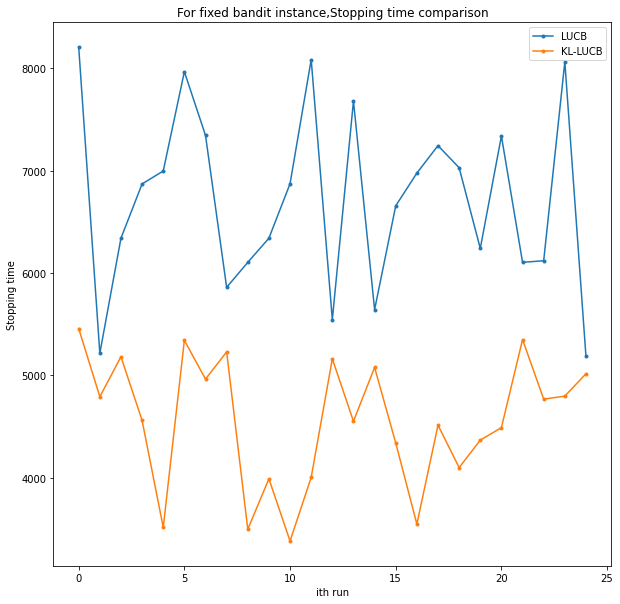

In [95]:
import matplotlib.pylab as plt
import numpy as np
f=plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
r=25
LUCB=np.zeros(r);KL_LUCB=np.zeros(r);median_elim=np.zeros(r);
for runs in range(r):
    LUCB[runs]=LUCB_main_func()
    KL_LUCB[runs]=KL_LUCB_main_func()
plt.plot(LUCB,marker='.',label="LUCB")
plt.plot(KL_LUCB,marker='.',label="KL-LUCB")



plt.ylabel('Stopping time')
plt.xlabel('ith run')
plt.title('For fixed bandit instance,Stopping time comparison')
plt.legend(loc='upper right')
plt.show()



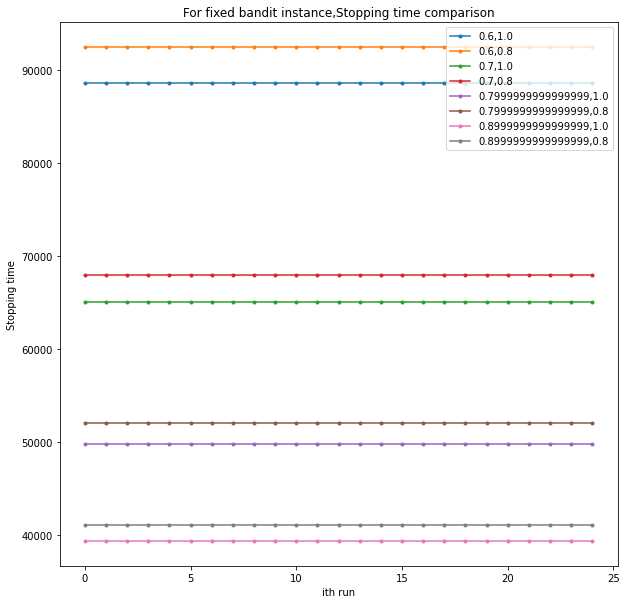

In [97]:
import matplotlib.pylab as plt
import numpy as np
f=plt.figure()
f.set_figwidth(10)
f.set_figheight(10)
r=25
median_elim=np.zeros(r);

for eps in np.arange(0.6,1,0.1):
    for delta in np.arange(1,0.6,-0.2):
        median_elim=np.zeros(r);
        for runs in range(r):
            median_elim[runs]=median_elimination_main_func(eps,delta)
        plt.plot(median_elim,marker='.',label=str(eps)+","+str(delta))
        
plt.ylabel('Stopping time')
plt.xlabel('ith run')
plt.title('For fixed bandit instance,Stopping time comparison')
plt.legend(loc='upper right')
plt.show()